# Loading and Processing Data

### Set up dataframe with category and image urls

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from skimage import data, io, filters

### Set up dataframe with category and image urls

import os
data = []
#!cp -r "../input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign" "./images"
#!cp -r "../input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/malignant" "./images"
#!cp -r "KI-67_segmentation" "./"
os.makedirs("images") 
os.makedirs("masks") 

SHAPE = (250,250)
for dirname, _, filenames in os.walk("KI-67_segmentation"):
    if "normal" not in dirname:
        for filename in filenames:
            if "mask" not in filename:
                d1 = dirname.split('/')[0]
                d2 = os.path.join('images', filename)
                d3 = os.path.join('masks',filename)
                os.replace(dirname+"/"+filename.replace('.jpg','') + ("_mask.png"), "masks/" + filename)
                os.replace(dirname+"/"+filename, "images/" + filename)
                #print(dirname+"/"+filename,filename)

                data.append([d1,d2,d3])
df = pd.DataFrame(data, columns=['category','image','mask'])
df

category          image          mask
0   KI-67_segmentation\A   images\1.jpg   masks\1.jpg
1   KI-67_segmentation\A  images\10.jpg  masks\10.jpg
2   KI-67_segmentation\A  images\11.jpg  masks\11.jpg
3   KI-67_segmentation\A  images\12.jpg  masks\12.jpg
4   KI-67_segmentation\A  images\13.jpg  masks\13.jpg
..                   ...            ...           ...
94  KI-67_segmentation\B  images\50.jpg  masks\50.jpg
95  KI-67_segmentation\B   images\6.jpg   masks\6.jpg
96  KI-67_segmentation\B   images\7.jpg   masks\7.jpg
97  KI-67_segmentation\B   images\8.jpg   masks\8.jpg
98  KI-67_segmentation\B   images\9.jpg   masks\9.jpg

[99 rows x 3 columns]

In [2]:
IMAGE_SIZE = (300,300)

for i in df.itertuples():
    img = io.imread(i.image)
    mask = io.imread(i.mask)
    

Index(['category', 'image', 'mask'], dtype='object')
<class 'pandas.core.frame.DataFrame'>


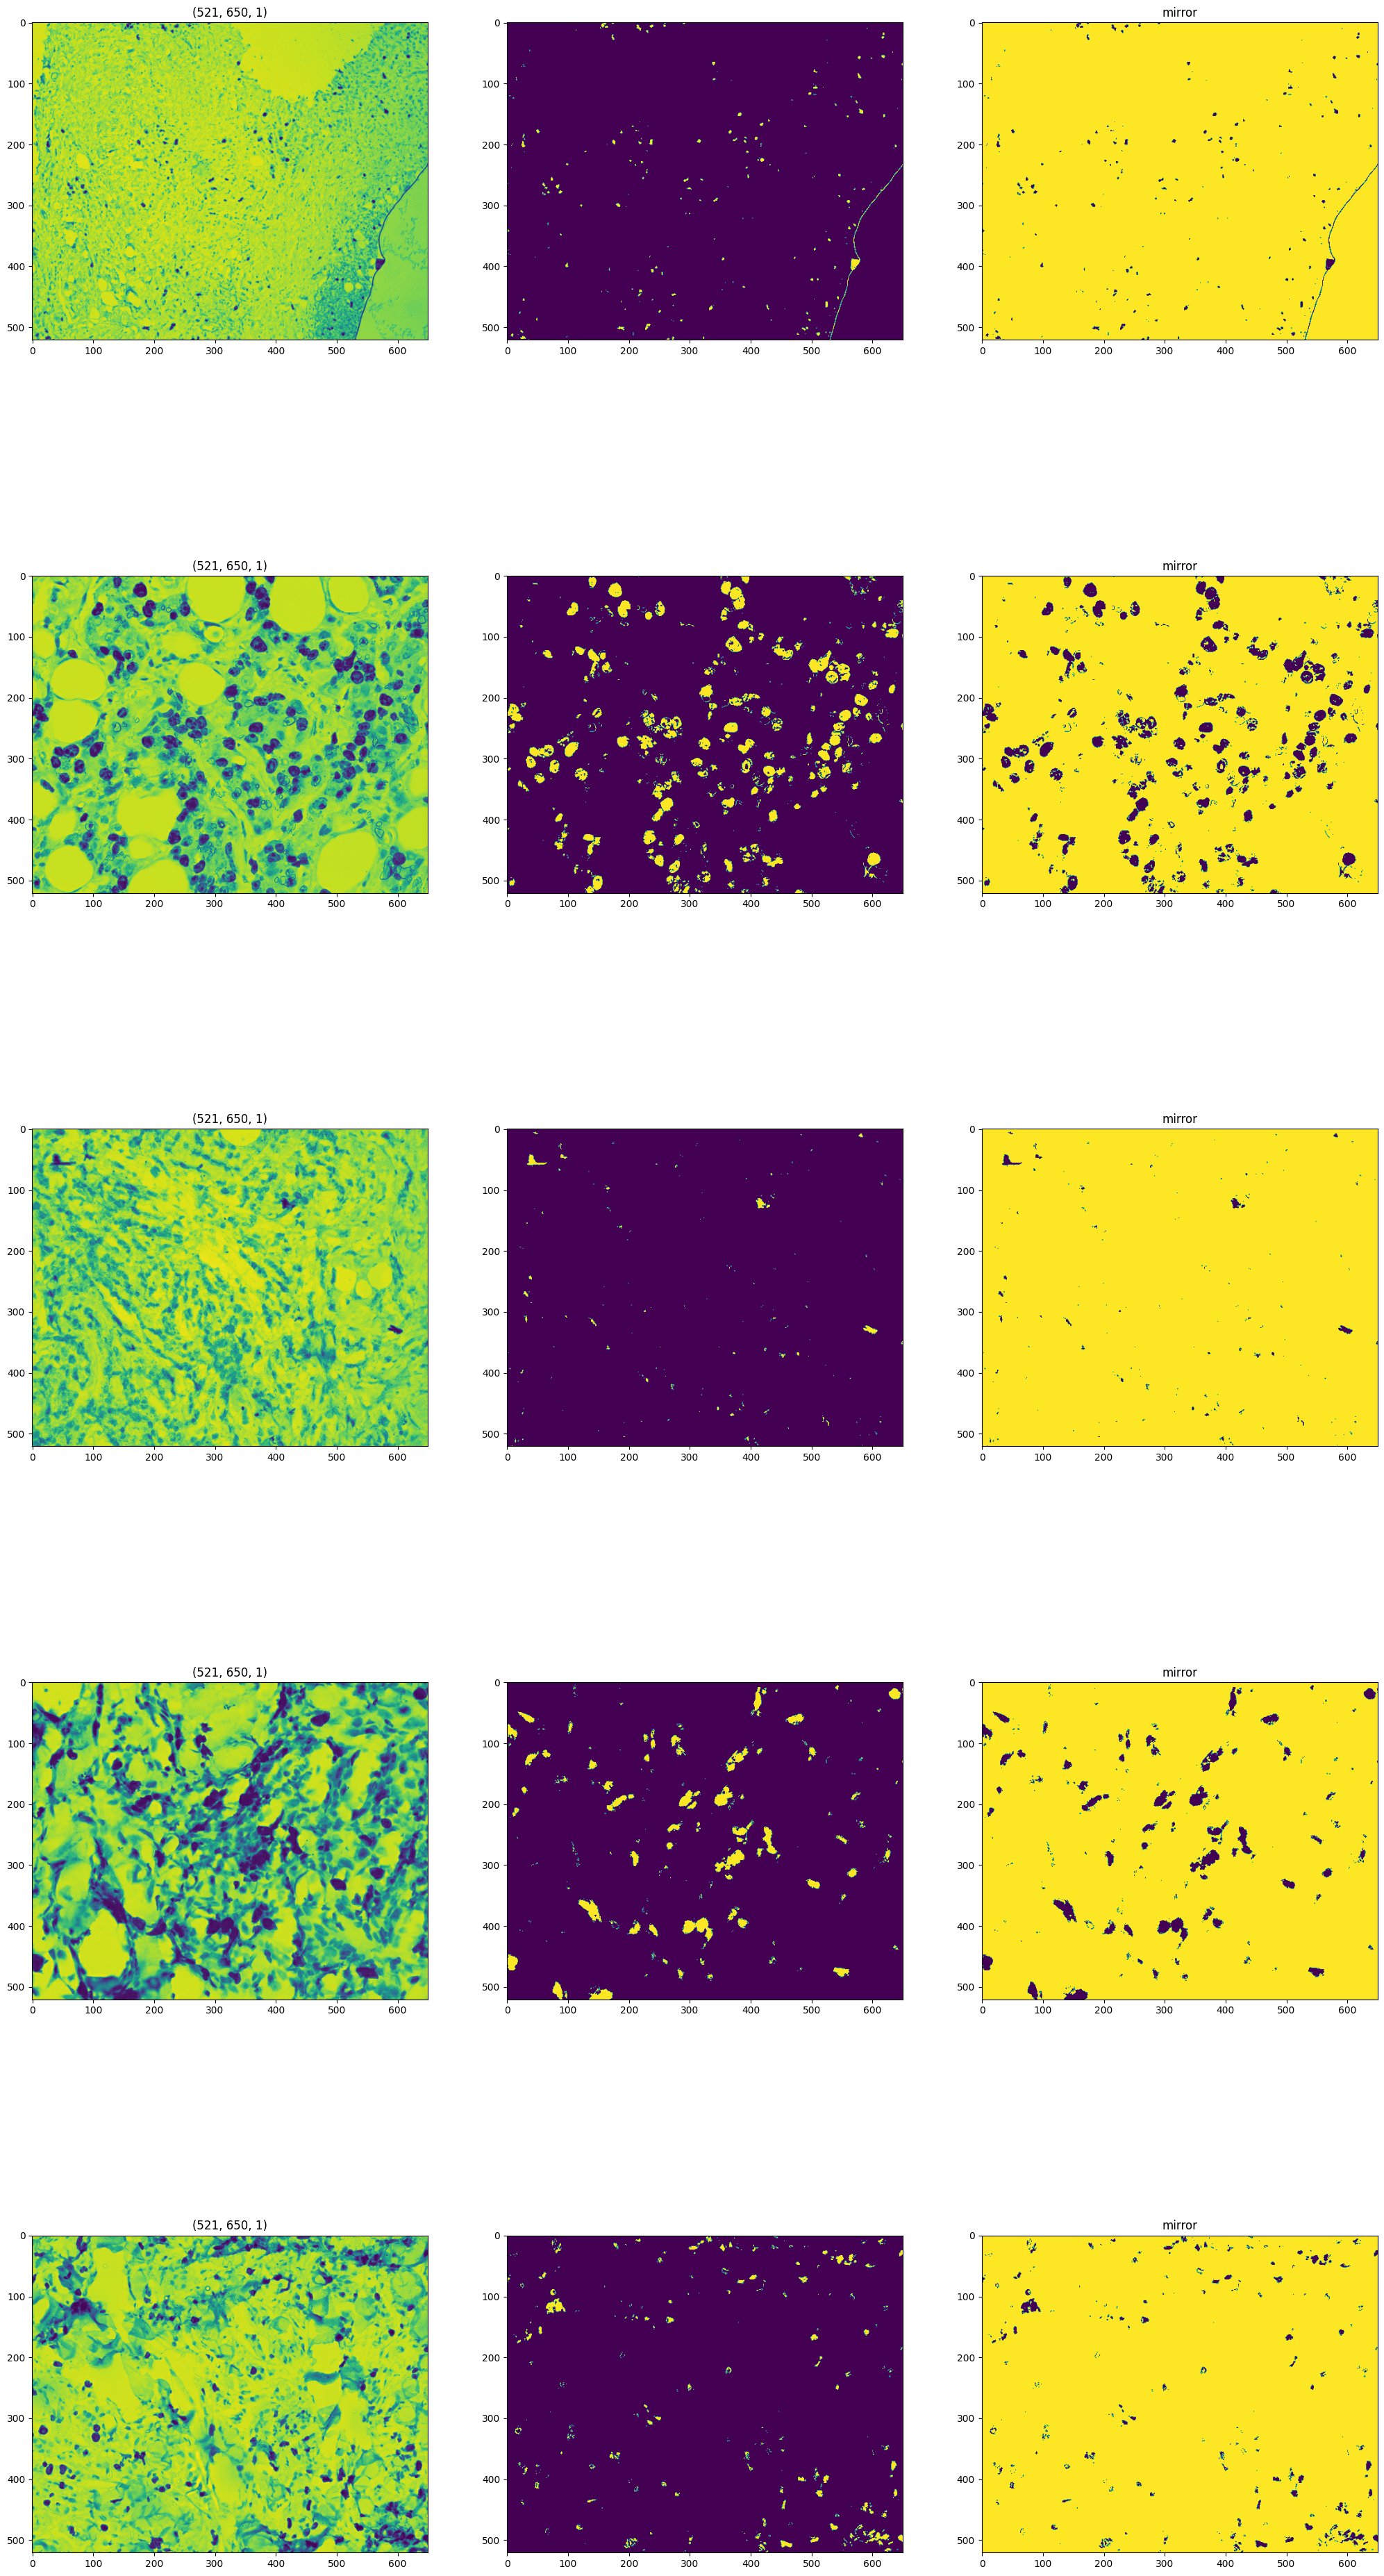

In [3]:
IMAGE_SIZE = (250,250)

n=5
samples = df.sample(n=n, random_state=1)
print(samples.columns)
print(type(samples))
fig, axs = plt.subplots(n,3,figsize=(n*5,n*10))

for idx,i in enumerate(samples.itertuples()):
    mask = tf.io.read_file(i.mask)
    img = tf.io.read_file(i.image)
    
    img = tf.image.decode_jpeg(img, channels=1)
    mask = tf.image.decode_jpeg(mask, channels=1)
    
    mask = tf.image.convert_image_dtype(mask, tf.float32)
    img = tf.image.convert_image_dtype(img, tf.float32)
    
    mirror = (mask+1)%2
    reshaped = tf.image.resize(img, size=[SHAPE[0],SHAPE[1]])    
    axs[idx,0].set_title(str(img.shape))
    axs[idx,0].imshow(img)
    axs[idx,1].imshow(mask)
    axs[idx,2].set_title(str("mirror"))
    axs[idx,2].imshow(mirror)    

In [4]:
# https://stackoverflow.com/questions/63458668/tensorflow-image-dataset-from-directory-for-input-dataset-and-output-dataset
#edit this stuff
def process_img(file_path,shape=SHAPE,ismask=False):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=1)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, size=[shape[0],shape[1]])
    if ismask:
        mirror = (img+1)%2
        return tf.concat([img,mirror],2)
    return img

# Models

We're gonna explore a few different state-of-the-art image segmentation models with focus on biomedical ultrasound images and compare them.

## U-net

Link to the paper: https://arxiv.org/abs/1505.04597

In [5]:
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import BatchNormalization, Input,UpSampling2D,Concatenate, MaxPooling2D,ReLU, Conv2D,Concatenate,Conv2DTranspose,Cropping2D,Dropout
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import AUC
from tensorflow.keras.optimizers import SGD

class U_Net():
    def __init__(self, inp=(572, 572, 1),min_filter=64,max_filter=1024, optimizer='Adam',loss=BinaryCrossentropy(), metrics = ['accuracy',AUC()]):
        self.max_filter = max_filter
        self.min_filter = min_filter
        self.img_inp = Input(shape = inp)
        down,cac,down_list = self.downsample()
        lower,down_list = self.contracting_path(down,down_list)
        upper,cac2 = self.upsample(lower,down_list)
        out = Conv2D(2,(1), activation="softmax", name='output')(upper)
        self.out = out
        self.model = keras.Model(inputs=self.img_inp, outputs=self.out)
        
        optimizer = tf.keras.optimizers.SGD(
            learning_rate=0.01, momentum=0.9,  name="SGD"
        )
        self.model.compile(optimizer=optimizer,loss=loss,metrics=metrics)
    
    def downsample(self):
        k = self.min_filter

        down_list = []
        res = self.img_inp
        while k < self.max_filter:
            res = Conv2D(k,(3,3))(res)
            res = ReLU()(res)
            #rest = Dropout(0.3)(res)
            res = Conv2D(k,(3,3))(res)
            res = ReLU()(res)
            #rest = Dropout(0.3)(res)
            down_list.append(res)
            cac = res
            res = MaxPooling2D(pool_size=(2, 2),strides=2)(res)
            curr = res
            k*=2
        return res,cac,down_list
    
    def upsample(self,res,down_list):
        k = self.max_filter
        i=0
        while k > self.min_filter:
            res = Conv2D(k/2,(3,3))(res)
            res = ReLU()(res)
            #rest = Dropout(0.3)(res)
            k/=2
            
            if k > self.min_filter:
                res = Conv2D(k/2,(3,3))(res)
                res = ReLU()(res)
                #rest = Dropout(0.3)(res)
                res = UpSampling2D((2,2))(res)
                left = down_list.pop()
                res = self.crop_and_conc(left,res)
                i+=1
            else:
                res = Conv2D(k,(3,3))(res)
                res = ReLU()(res)
                #rest = Dropout(0.3)(res)
            cac = res
            curr = res
        return res,cac
    
    def contracting_path(self,down,down_list):
        res = Conv2D(self.max_filter,(3,3))(down)
        res = ReLU()(res)
        #rest = Dropout(0.3)(res)
        res = Conv2D(self.max_filter/2,(3,3))(res)
        res = ReLU()(res)
        #rest = Dropout(0.3)(res)
        res = UpSampling2D((2,2))(res)
        left = down_list.pop()
        res = self.crop_and_conc(left,res)
        return res,down_list
    
    
    def crop_and_conc(self,left,right):
        left = Cropping2D(cropping=int((left.shape[1]-right.shape[1])/2))(left)
        right = Concatenate()([left,right])
        return right

In [6]:
shape = (300,300,1)

model = U_Net(inp=shape)
model.model.summary()
dot_img_file = 'model.png'
tf.keras.utils.plot_model(model.model, to_file=dot_img_file, show_shapes=False)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300, 300, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 298, 298, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 re_lu (ReLU)                   (None, 298, 298, 64  0           ['conv2d[0][0]']                 
                                )                                                             

                                                                                                  
 concatenate_1 (Concatenate)    (None, 36, 36, 512)  0           ['cropping2d_1[0][0]',           
                                                                  'up_sampling2d_1[0][0]']        
                                                                                                  
 conv2d_12 (Conv2D)             (None, 34, 34, 256)  1179904     ['concatenate_1[0][0]']          
                                                                                                  
 re_lu_12 (ReLU)                (None, 34, 34, 256)  0           ['conv2d_12[0][0]']              
                                                                                                  
 conv2d_13 (Conv2D)             (None, 32, 32, 128)  295040      ['re_lu_12[0][0]']               
                                                                                                  
 re_lu_13 

In [7]:
from glob import glob

x_files = glob('images/*.jpg')
y_files = glob('masks/*.jpg')
files_ds = tf.data.Dataset.from_tensor_slices((x_files, y_files))
mask_shape = model.model.get_layer('output').output_shape
print(mask_shape[1:])
files_ds = files_ds.map(lambda x, y: (process_img(x,shape), process_img(y,mask_shape[1:],ismask=True))).batch(1)

print(type(files_ds))

    
batch_size = 32
LR = 1e-2
epochs = 5
history = model.model.fit(files_ds,epochs=epochs, batch_size=batch_size)

(116, 116, 2)
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>
Epoch 1/5
50/50 [==============================] - 99s 2s/step - loss: 0.3316 - accuracy: 0.9239 - auc: 0.9632
Epoch 2/5
50/50 [==============================] - 93s 2s/step - loss: 0.0870 - accuracy: 0.9825 - auc: 0.9700
Epoch 3/5
50/50 [==============================] - 93s 2s/step - loss: 0.0862 - accuracy: 0.9825 - auc: 0.9700
Epoch 4/5
50/50 [==============================] - 93s 2s/step - loss: 0.0861 - accuracy: 0.9825 - auc: 0.9700
Epoch 5/5
50/50 [==============================] - 92s 2s/step - loss: 0.0860 - accuracy: 0.9825 - auc: 0.9699


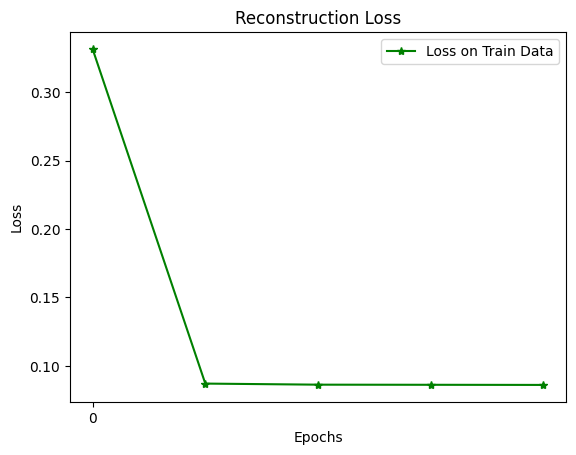

In [8]:
plt.title("Reconstruction Loss")
epochs=len(history.history['loss'])
plt.plot(np.arange(0,epochs),history.history['loss'],label="Loss on Train Data", marker='*',color='green')

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(0,epochs,5),np.arange(0,epochs,5))
plt.legend()
plt.show()

1/1 [==============================] - 1s 848ms/step


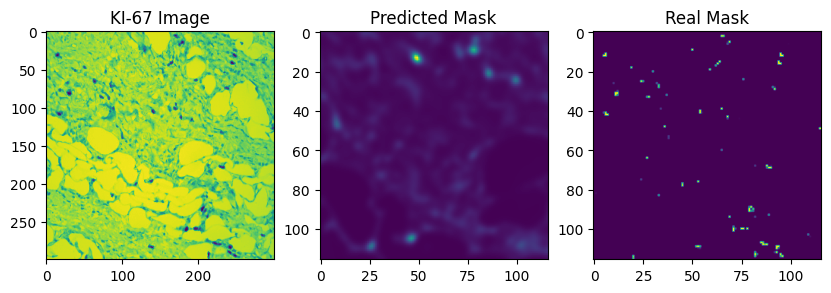

1/1 [==============================] - 0s 422ms/step


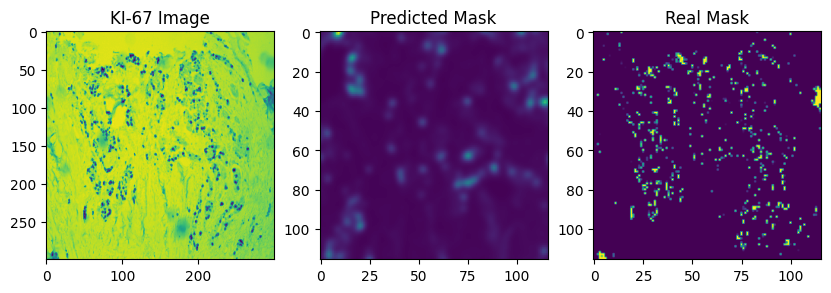

1/1 [==============================] - 0s 422ms/step


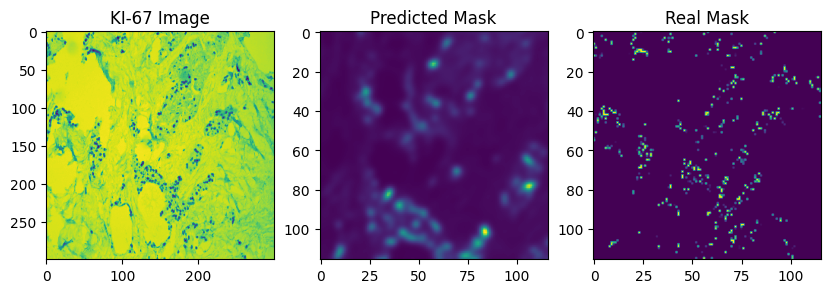

1/1 [==============================] - 1s 529ms/step


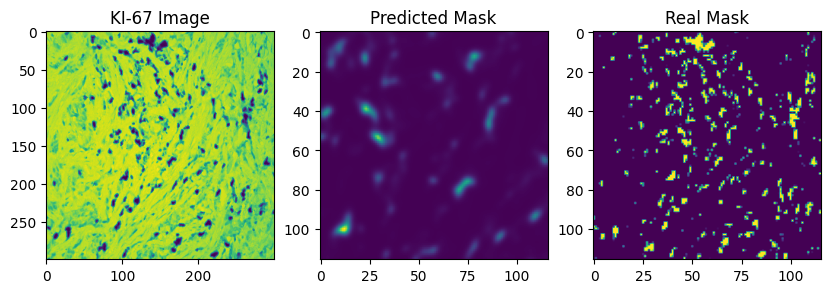

1/1 [==============================] - 0s 420ms/step


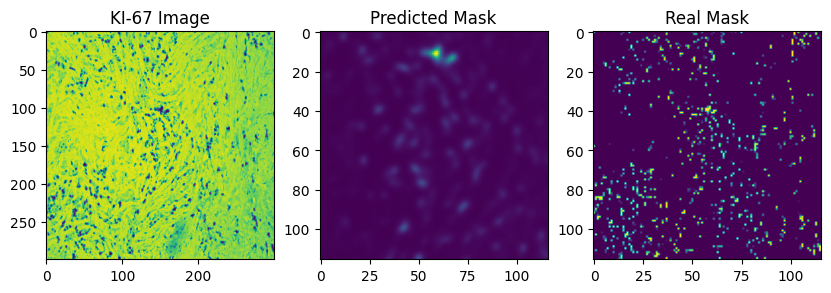

In [9]:
n=5

for i,file in enumerate(x_files):
    x_img = process_img(x_files[i],shape)
    y_img = process_img(y_files[i],mask_shape[1:],ismask=True)
    new_shape = tf.reshape(x_img,[1,x_img.shape[0],x_img.shape[1],x_img.shape[2]])
    new_mask = model.model.predict(new_shape)[0]
    fig, axs = plt.subplots(1,3,figsize=(10,100))
    axs[0].set_title("KI-67 Image")
    axs[0].imshow(x_img[:,:,0])
    axs[1].set_title("Predicted Mask")
    axs[1].imshow(new_mask[:,:,0])
    axs[2].set_title("Real Mask")
    axs[2].imshow(y_img[:,:,0])  
    plt.show()
    
    if i == n-1:
        break
